<a href="https://www.kaggle.com/mohamedmoghazy/implementing-pca-and-sgd-from-scratch?scriptVersionId=88658142" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Hello Kagglers 
In this notebook I am going to show you what happens under the hood in 
1. PCA (principle component analysis) 
1. SGD (stochastic gradient descent)

**The main purpose of this notebook is to implement both of them from scratch , not to get a high score, but it achieved the best public score and came the fifth in the private score, so let's get started**

In [1]:
import numpy as np 
from numpy import linalg as LA
import pandas as pd 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('/kaggle/input/neolen-house-price-prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/neolen-house-price-prediction/test.csv')

In [3]:
# Dropping 'Id' column as it has no use in training
train_df = train_df.drop(['Id'], axis=1)
test_df = test_df.drop(['Id'], axis=1)
labels=train_df["SalePrice"]
data = pd.concat([train_df,test_df],ignore_index=True)
data = data.drop("SalePrice", 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [4]:
print(f"Shape of train set: {train_df.shape}")
print(f"Shape of test set: {test_df.shape}")

Shape of train set: (1259, 80)
Shape of test set: (201, 79)


In [5]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [7]:
# Count the number of NaNs each column has.
nans=pd.isnull(data).sum()
nans[nans>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
# Remove columns with more than a thousand missing values
data=data.drop("PoolQC", 1)
data=data.drop("Fence", 1)
data=data.drop("MiscFeature", 1)
data=data.drop("Alley", 1)
data=data.drop("LotFrontage", 1)
data=data.drop("MasVnrArea", 1)
data=data.drop("GarageYrBlt", 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a futur

In [9]:
# Count the column types
data.dtypes.value_counts()

object    39
int64     33
dtype: int64

In [10]:
# One Hot Encoding
data = pd.get_dummies(data)
data.fillna(0)
# Change -inf to 0 again
data[data==-np.inf]=0

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 272 entries, MSSubClass to SaleCondition_Partial
dtypes: int64(33), uint8(239)
memory usage: 717.3 KB


# Now we start the first steps toward our dimensionality reduction algorithm
**Here I implemented principle component analysis using the eigen decomposition, so I will start first by making all the data in the normal distribution form by subtracting the mean from all of them and then divide by the standard deviation**

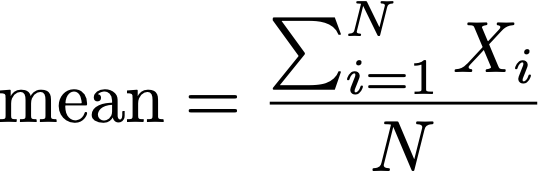

In [12]:
#function to calculate the mean of each feature
def avg(x): 
    s = np.sum(x,axis=0) 
    s = s/x.shape[0] 
    return s

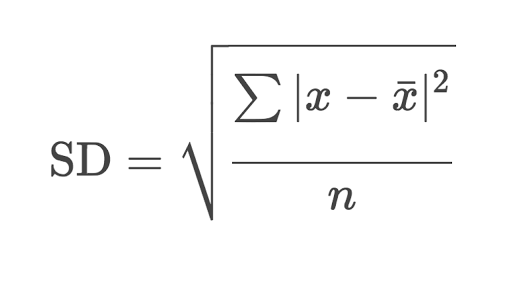

In [13]:
#function to calculate the standard deviation of each feature
def std(x):
  m = avg(x)
  s = np.subtract(x,m)
  s = np.power(s,2)
  c = s.shape
  s = np.sum(s,axis=0)
  s = np.divide(s, c[0]-1)
  s = np.sqrt(s)
  return s


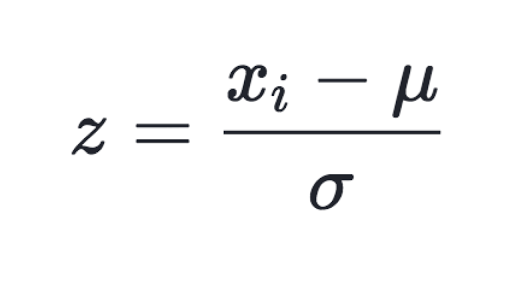

In [14]:
#function to standerdize data
def standardize(x):
  A = avg(x)
  S = std(x)
  x = np.subtract(x,A)
  x = np.divide(x,S)
  return x

In [15]:
data_standard = standardize(data)
data_standard.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,...,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,-3.832551e-17,-7.726411e-17,1.729210e-16,2.133757e-16,1.041937e-15,4.503855e-15,-1.262308e-17,1.540625e-16,-8.379903e-17,2.364547e-16,...,-2.617674e-16,1.062316e-16,-4.224931e-16,-2.832590e-16,-3.906312e-16,-6.298805e-16,7.931251e-17,-6.216489e-18,1.494239e-16,-6.653734e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.722639e-01,-9.234128e-01,-3.687150e+00,-4.111561e+00,-3.286697e+00,-1.688790e+00,-9.726849e-01,-2.885540e-01,-1.283736e+00,-2.410341e+00,...,-5.860096e-02,-3.018583e-01,-4.536094e-02,-2.561302e+00,-2.725224e-01,-5.239629e-02,-9.100339e-02,-1.178108e-01,-2.137613e+00,-3.058902e-01
25%,-8.722639e-01,-2.968890e-01,-7.948791e-01,-5.170227e-01,-5.717268e-01,-8.653621e-01,-9.726849e-01,-2.885540e-01,-7.790590e-01,-5.964811e-01,...,-5.860096e-02,-3.018583e-01,-4.536094e-02,3.901589e-01,-2.725224e-01,-5.239629e-02,-9.100339e-02,-1.178108e-01,4.674912e-01,-3.058902e-01
50%,-1.630536e-01,-1.040277e-01,-7.181151e-02,-5.170227e-01,5.735183e-02,4.424348e-01,-1.318570e-01,-2.885540e-01,-2.030937e-01,-1.502819e-01,...,-5.860096e-02,-3.018583e-01,-4.536094e-02,3.901589e-01,-2.725224e-01,-5.239629e-02,-9.100339e-02,-1.178108e-01,4.674912e-01,-3.058902e-01
75%,3.097533e-01,1.086708e-01,6.512561e-01,3.816120e-01,9.513056e-01,9.268040e-01,5.889309e-01,-2.885540e-01,5.448690e-01,5.489346e-01,...,-5.860096e-02,-3.018583e-01,-4.536094e-02,3.901589e-01,-2.725224e-01,-5.239629e-02,-9.100339e-02,-1.178108e-01,4.674912e-01,-3.058902e-01
max,3.146594e+00,2.051125e+01,2.820459e+00,3.077516e+00,1.282400e+00,1.217426e+00,1.140185e+01,8.848606e+00,4.002923e+00,1.151700e+01,...,1.705288e+01,3.310544e+00,2.203030e+01,3.901589e-01,3.666910e+00,1.907225e+01,1.098108e+01,8.482375e+00,4.674912e-01,3.266908e+00


**We will calculate the covariance matrix between the features and themselves here as the following equation**
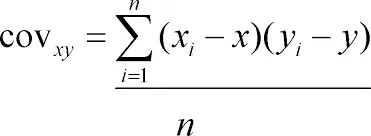

In [16]:
#function to calculate the covariance matrix
def cov(x):
  cov = np.dot(x.T,x)
  cov = np.divide(cov,x.shape[0])
  return cov

In [17]:
cov_matrix = cov(data_standard)

# The next step:
**Now we calculate the eigen vectors and eigen values, the idea here is to know which vectors are not affected by linear transformation and still span the same space, their norm might change and thats what the eigen value represent**

In [18]:
e,v = LA.eig(cov_matrix)
e=e.real
v=v.real

**The eigen values here represent the variance in each feature, if the eigen value is high it means that the variance in features on this axis is significantly high and can represent the projections of many feature, so I took the first 130 vectors from the 277**

In [19]:
e[:130]

array([17.34340436,  8.10783023,  6.45158115,  5.45491977,  4.771643  ,
        4.42439583,  4.04655699,  3.44747508,  3.37935923,  3.20338548,
        3.09145474,  2.96757982,  2.88088896,  2.82144988,  2.75419793,
        2.68849734,  2.6042613 ,  2.49969235,  2.47635445,  2.43520439,
        2.39206931,  2.34151532,  2.3048293 ,  2.2374616 ,  2.20882494,
        2.18597188,  2.18187606,  2.14512854,  2.09621007,  2.09051852,
        2.06844919,  2.0354012 ,  1.97574394,  1.95026602,  1.94168661,
        1.89721702,  1.88284117,  1.86043085,  1.8412325 ,  1.8201796 ,
        1.77395492,  1.76012724,  1.73357777,  1.6969821 ,  1.68020853,
        1.66975565,  1.64022976,  1.63153371,  1.59461865,  1.58732563,
        1.57966841,  1.52796427,  1.53015064,  1.50525293,  1.4935394 ,
        1.46721055,  1.46261907,  1.44847236,  1.4183021 ,  1.40963687,
        1.38889579,  1.38325435,  1.34293717,  1.35007412,  1.37011778,
        1.31629476,  1.31082362,  1.29543803,  1.28875525,  1.27

In [20]:
axes = v[:,:130]
axes

array([[-0.00560649, -0.10037309,  0.07353703, ..., -0.01758622,
        -0.01201921,  0.01434701],
       [ 0.03205108,  0.08718267, -0.1877258 , ...,  0.05355378,
         0.0677325 , -0.08936603],
       [ 0.19068034, -0.05268459, -0.07740431, ...,  0.00135949,
        -0.1964336 , -0.35008538],
       ...,
       [-0.00882071,  0.00598723, -0.00524233, ..., -0.00098127,
         0.00924511,  0.01008208],
       [-0.05022675,  0.06150564,  0.05200192, ..., -0.00147032,
         0.00253724, -0.01107302],
       [ 0.10558936, -0.08940222, -0.04428405, ..., -0.00660938,
         0.00485166, -0.0085174 ]])

**Now we transform the data by multiplying it by the vectors representing the projections**

In [21]:
transformed_data = np.dot(data_standard,axes)
transformed_data

array([[ 4.12511275, -1.39010007,  2.54563669, ...,  0.00926379,
         0.06531775,  0.04504937],
       [-0.07852945,  3.30569645,  0.40782581, ...,  0.01947366,
         0.06495144,  0.0795121 ],
       [ 4.79177463, -0.77011383,  1.78614496, ...,  0.08174606,
         0.39830375, -0.00786187],
       ...,
       [ 1.40117602, -2.02312   , -2.26670697, ...,  0.1949261 ,
         0.46343642, -0.44843038],
       [-3.0032046 ,  3.49575011,  0.46426165, ..., -1.40931508,
        -1.23676847, -1.00619167],
       [-1.2476175 ,  3.88383665,  1.10021012, ...,  0.02458153,
         0.60417025,  0.453144  ]])

In [22]:
# Split traing and test
train = transformed_data[:1259]
test = transformed_data[1259:]

**Here I added a column of ones to the data to be multiplied by the bias vector later**

In [23]:
train = np.append(np.ones((1259,1)),train, axis=1)
print(train.shape)
print(test.shape)
labels = labels.values.reshape(-1,1)
labels.shape

(1259, 131)
(201, 130)


(1259, 1)

# Stochastic gradient descent function
This function can be used as batch gradient descent if we gice batch size equal to the size of the data, also can be used as mini-batch if we decrease the batch size, and as stochastic gradient descent if we make the batch size equal to one 

In [24]:
#takes as the argument, data , labels,learning rate, no. of epochs and batch size


def SGD(Data,Labels,LR,no_iter,batch_size):
    
    


    max_iter = no_iter
    alpha2 = LR
    loss2 = []
    X2 = Data
    Y2 = Labels
    theta = np.zeros(131)
    theta = theta.reshape(-1,1)
    m,n =X2.shape
    num_batches = m//batch_size

  #the next for loop is to train for the required number of epochs
    for i in range (1,max_iter):
    
#this for loop is to train for each batch

          for batch_num in range(num_batches):
        
        #slicing the data for each batch
                x = X2[batch_num*batch_size:(batch_num+1)*batch_size,:]
                y = Y2[batch_num*batch_size:(batch_num+1)*batch_size]

                #getting output based on current parameters(thetas)
                h2 = x@theta
                
                #calculating cost function :((predictions-labels)**2)/n
                J2 = np.subtract(h2,y)
                J2 = np.power(J2,2)
                J2 = np.divide(J2, 2*h2.shape[0])
                #getting the norm of the cost vector and adding it to the list of costs
                cost2 = np.linalg.norm(J2)
                loss2.append(cost2)


                #calculating the gradients: ((predictions-labels) * data)/2n
                #this function can be easily deducted by taking the first derivative of the cost function
                theta_grad = np.subtract(h2,y)
                theta_grad = x.T@theta_grad
                theta_grad = np.divide(theta_grad,h2.shape[0])
                
                #multiplying the gradient(step) with the learning rate
                theta_grad = np.multiply(alpha2,theta_grad)


                #the next piece of code is made in case if the data divided by batch size doesnt give an integar value
                
                remaining = m - num_batches*batch_size
                if num_batches*batch_size<m:
                    x = X2[num_batches*batch_size:,:]
                    y  = Y2[num_batches*batch_size:]

                    h2 = x@theta
                    J2 = np.subtract(h2,y)
                    J2 = np.power(J2,2)
                    J2 = np.divide(J2, 2*h2.shape[0])
                    cost2 = np.linalg.norm(J2)
                    loss2.append(cost2)


                    theta_grad = np.subtract(h2,y)
                    theta_grad = x.T@theta_grad
                    theta_grad = np.divide(theta_grad,h2.shape[0])
                    theta_grad = np.multiply(alpha2,theta_grad)
                
                #updating the parameters : theta-gradient
                theta = np.subtract(theta,theta_grad, dtype=np.float128)


    return theta,loss2

In [25]:
#training our model
theta,loss = SGD(train,labels,0.0001,1200,1)

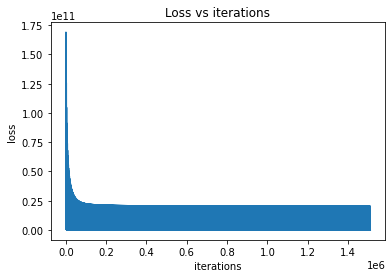

In [26]:
iterations = list(range(0,len(loss)))



# plotting the points
plt.plot(iterations, loss)
 
# naming the x axis
plt.xlabel('iterations')
# naming the y axis
plt.ylabel('loss')
 
# giving a title to my graph
plt.title('Loss vs iterations')
 
# function to show the plot
plt.show()  

In [27]:
#getting predictions for our data
h = train@theta

In [28]:
r2_score(labels,h)

0.9026981751306066

<AxesSubplot:>

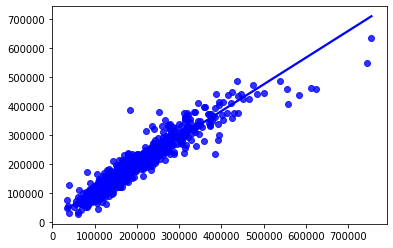

In [29]:
sns.regplot(x=labels, y=h, ci=None, color="b")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

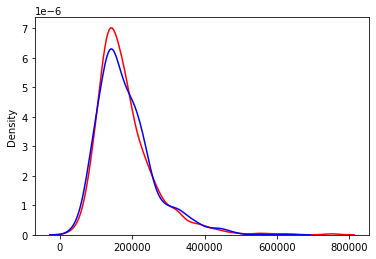

In [30]:
ax1 = sns.distplot(labels, hist=False, color="r", label="Actual Value")
sns.distplot(h, hist=False, color="b", label="Fitted Values" , ax=ax1)

In [31]:
test = np.append(np.ones((201,1)),test, axis=1)

In [32]:
h = test@theta

In [33]:
h=h.reshape(-1,)

In [34]:
# Save test predictions to file
output = pd.DataFrame({'Id': pd.DataFrame(test).index+1260,
                       'SalePrice': h})
output.to_csv('submission.csv', index=False)
print('done')

done
